# Arsenal in the English Premiership  from 2009-2010 season till date.

This project is an analysis and visualization of the performance of Arsenal Football Club over the last 10 seasons in the English Premiership. The datasets used in this project have been pulled from https://datahub.io/sports-data/english-premier-league#data.  
The performance measures of interest are:
1. Win percentage against each of the teams faced in the 10 season period.
2. Win percentage by the officiating referees .....

### Import required libraries for data analysis and visualization.
Pandas is required for data analysis and 
Bokeh is required for data visualization

In [115]:
#Import required libraries
#pip install datatable not on windows
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from bokeh.models.widgets import Panel, Tabs
from bokeh.io import show, output_file
from bokeh.plotting import figure, gmap
from bokeh.models import ColumnDataSource,GMapOptions, HoverTool, LinearInterpolator, CategoricalColorMapper
from bokeh.models.glyphs import MultiLine
from bokeh.plotting import figure, show, output_notebook
from bokeh.tile_providers import get_provider, Vendors
from bokeh.palettes import Category10
%matplotlib inline

### Read in data from url
This dataset contains data for last 10 seasons of English Premier League from 2009-2019. Data for each season is recorded in a separate csv file.

In [280]:
dateparse = lambda x: pd.datetime.strptime(x, '%d/%m/%y')
dp = lambda x: pd.datetime.strptime(x, '%d/%m/%y')
season_one = pd.read_csv("https://datahub.io/sports-data/english-premier-league/r/season-0910.csv",parse_dates=['Date'])
season_two = pd.read_csv("https://datahub.io/sports-data/english-premier-league/r/season-1011.csv",parse_dates=['Date'], date_parser=dateparse)   
season_three = pd.read_csv("https://datahub.io/sports-data/english-premier-league/r/season-1112.csv",parse_dates=['Date'], date_parser=dateparse)
season_four = pd.read_csv("https://datahub.io/sports-data/english-premier-league/r/season-1213.csv",parse_dates=['Date'], date_parser=dateparse) 
season_five = pd.read_csv("https://datahub.io/sports-data/english-premier-league/r/season-1314.csv",parse_dates=['Date'], date_parser=dateparse)
season_six = pd.read_csv("https://datahub.io/sports-data/english-premier-league/r/season-1415.csv", parse_dates=['Date'], date_parser=dateparse)
season_seven = pd.read_csv("https://datahub.io/sports-data/english-premier-league/r/season-1516.csv",parse_dates=['Date'], date_parser=dateparse) 
season_eight = pd.read_csv("https://datahub.io/sports-data/english-premier-league/r/season-1617.csv",parse_dates=['Date'], date_parser=dateparse)
season_nine = pd.read_csv("https://datahub.io/sports-data/english-premier-league/r/season-1718.csv",parse_dates=['Date'], date_parser=dateparse)  
season_ten = pd.read_csv("https://datahub.io/sports-data/english-premier-league/r/season-1819.csv")
season_ten['Date'] = pd.to_datetime(season_ten['Date'], format='%d/%m/%Y')

### Merge all 10 dataframes into a single dataframe

In [281]:
allseasons = pd.concat([season_one,season_two,season_three,season_four,season_five,season_six,season_seven,season_eight,
                       season_nine,season_ten], sort=False)      

### Enrich Data  by retrieving the stadium locations for each team in the dataset 
Pull data from the Wikipedia page entry for the <a href="https://en.wikipedia.org/wiki/List_of_Premier_League_stadiums">Premier League Stadia</a>.

In [282]:
# Create a dictionary of 8 regions
region = {"Anglia":["Norwich City", "Leicester City"],
          "West Midlands":["Aston Villa","Birmingham City","West Bromwich Albion", "Stoke City", "Wolverhampton Wanderers"],
          "Wales":["Swansea City","Cardiff City"], "London": ["Watford","Reading","Chelsea", "Fulham", "Arsenal", "Crystal Palace","West Ham United", 
         "Queens Park Rangers", "Tottenham Hotspur"], 
          "Yorkshire":["Hull City", "Huddersfield Town"],
          "NorthEast": ["Sunderland","Middlesbrough","Newcastle United"],
         "NorthWest": ["Wigan Athletic","Burnley","Everton","Liverpool","Manchester United","Manchester City", "Blackpool", "Bolton Wanderers","Blackburn Rovers"], 
          "South": ["Southampton","Portsmouth", "Bournemouth", "Brighton & Hove Albion"]}
# Setup list for clubs to drop
clubs_to_drop = ['Oldham Athletic','Ipswich Town','Charlton Athletic','Bradford City', 'Swindon Town', 'Nottingham Forest', 'Barnsley',\
                 'Ipswich Town', 'Leeds United', 'Sheffield Wednesday', 'Sheffield United', 'Derby County']
# Read stadium data from wikipedia page
stadia = pd.read_html("https://en.wikipedia.org/wiki/List_of_Premier_League_stadiums", header = 0)
columns = ['Club','Stadium','Coordinates', 'Closed', 'Opened']
stadia = stadia[0][columns]

# Drop stadia closed before 2009
stadia = stadia[~stadia['Closed'].isin(list(range(1991,2009)))].reset_index(drop = True)

# Drop clubs that have not particpated since 2009
stadia = stadia[~stadia['Club'].isin(clubs_to_drop)].reset_index(drop = True)

# Clean Club columns for Queens Park Rangers and Crystal Palace
stadia['Club'].replace("Crystal Palace & Wimbledon", "Crystal Palace", inplace = True)
stadia['Club'].replace("Queens Park Rangers& Fulham", "Queens Park Rangers", inplace = True)

# map region dictionary to dataframe
region = {k: oldk for oldk, oldv in region.items() for k in oldv}
stadia['Region'] = stadia['Club'].map(region)

# Drop duplicate data for West Ham and Totteham Hotspur
stadia.drop_duplicates(subset ="Club",inplace=True)

#st = set(stadia['Club'].unique())
#ts = set(allseasons['HomeTeam'].unique())
#cb = [x for x in st if x not in ts]

# Update the club names in the allseason dataframe to the full names of the clubs
allseasons['HomeTeam'].replace(np.sort(allseasons['HomeTeam'].unique()), np.sort(stadia['Club'].unique()), inplace = True)
allseasons['AwayTeam'].replace(np.sort(allseasons['AwayTeam'].unique()), np.sort(stadia['Club'].unique()), inplace = True)

### Utility functions for Feature Engineering and transform the dataset
Functions check_latitude and check_longitutde extract the geo-coordinates from the Coordinates column in the dataframe

In [283]:
# Function to extract latitude and transform to a 
def check_latitude(row):
    #latitude = ""
    longitude = "-"
    r_major = 6378137.000
    longitude += row['Coordinates'].split('/')[1].split(" ")[2].replace(u'\ufeff', '')
    longitude = float(longitude[:-2])
    x = r_major * math.radians(longitude)
    return x    
    
def check_longitude(row):
    latitude = ""
    longitude = "-"
    r_major = 6378137.000
    latitude += row['Coordinates'].split('/')[1].split(" ")[1].replace(u'\ufeff', '')
    longitude += row['Coordinates'].split('/')[1].split(" ")[2].replace(u'\ufeff', '')
    longitude = float(longitude[:-2])
    latitude = float(latitude[:-2])
    x = r_major * math.radians(longitude)
    scale = x/longitude    
    y  = 180.0 / math.pi * math.log(math.tan(math.pi/4.0 + latitude * (math.pi/180)/2.0)) * scale
    return y

In [284]:
# Process the Coordinates columns and split to Latitude and Lonigtude Columns
stadia.loc[:, 'Y_Coords'] = stadia.apply(check_longitude, axis = 1)
stadia.loc[:, 'X_Coords'] = stadia.apply(check_latitude, axis = 1)
to_drop = ['Coordinates','Closed','Opened']
stadia.drop(to_drop, axis=1, inplace = True)
stadia.sort_values(by=['Club'], inplace = True)
stadia.set_index('Club', inplace = True)

### Select games where Arsenal played home or away: 38 games per season (380 games in total).

In [285]:
# Slice the dataframe to select rows where Arsenal either Away or at Home
allseasonsArsenal = allseasons[(allseasons['AwayTeam'] == 'Arsenal') | (allseasons['HomeTeam'] == 'Arsenal')]

### Quick plot showing the referees who have officiated who have officiated Arsenal games

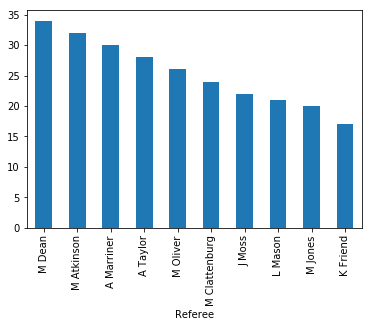

In [286]:
allseasonsArsenal.groupby(['Referee']).size().nlargest(10).plot(kind='bar')

### Check the result type: W for Win , D for draw and L for Loss

In [287]:
def check_results(row):
    result = ""
    res = row['FTR']
    team1 = row['HomeTeam']
    team2 = row['AwayTeam']
    if (team1 == 'Arsenal') & (res == 'H'):
        result = 'W'
    elif (team1 == 'Arsenal') & (res == 'A'):
        result = 'L'
    elif (team2 == 'Arsenal') & (res == 'A'):
        result = 'W'
    elif (team2 == 'Arsenal') & (res == 'H'):
        result = 'L'
    else:
        result = 'D'       

    return result

### Function to assign points to the result: 1 Point for Draw/Tie, 0 Points for a loass and 3 points for a win

In [288]:
def check_points(row):
    points = 0
    result = row['Result']
    if result == 'D':
        points = 1
    elif result == 'W':
        points = 3
    else:
        points = 0    
    return points

### Determine the season the match was played based on the date interval. Season  starts in August and ends in May 

In [289]:
def check_season(row):
    season = ""
    date = row['Date']
    if   (date >= pd.to_datetime('2009-08-05')) & (date <= pd.to_datetime('2010-05-21')):
        season += "09-10"
    elif (date >= pd.to_datetime('2010-08-14')) & (date <= pd.to_datetime('2011-05-23')):
        season += "10-11"
    elif (date >= pd.to_datetime('2011-08-13')) & (date <= pd.to_datetime('2012-05-13')):
        season += "11-12"
    elif (date >= pd.to_datetime("2012-08-18")) & (date <= pd.to_datetime("2013-05-19")): 
        season += "12-13" 
    elif (date >= pd.to_datetime("2013-08-17")) & (date <= pd.to_datetime("2014-05-11")): 
        season += "13-14" 
    elif (date >= pd.to_datetime("2014-08-16")) & (date <= pd.to_datetime("2015-05-24")): 
        season += "14-15" 
    elif (date >= pd.to_datetime("2015-08-08")) & (date <= pd.to_datetime("2016-05-15")): 
        season += "15-16" 
    elif (date >= pd.to_datetime("2016-08-13")) & (date <= pd.to_datetime("2017-05-21")): 
        season += "16-17" 
    elif (date >= pd.to_datetime("2017-08-11")) & (date <= pd.to_datetime("2018-05-13")):
        season += "17-18"
    elif (date >= pd.to_datetime("2018-08-05")) & (date <= pd.to_datetime("2019-05-20")):
        season += "18-19"
    else:
        season = season
    return season

### Create new columns for results, pints, season and progress(The Sum of points accrued per season)

In [292]:
allseasonsArsenal.loc[:,'Result'] = allseasonsArsenal.apply(check_results, axis = 1)
allseasonsArsenal.loc[:,'Points'] = allseasonsArsenal.apply(check_points, axis = 1)
allseasonsArsenal.loc[:,'Season'] = allseasonsArsenal.apply(check_season, axis = 1)
allseasonsArsenal.loc[:,'Progress'] = allseasonsArsenal.groupby('Season')['Points'].cumsum() 

### Function to calculate the results by the referee who officiated

In [18]:
def win_percent_by_referee(df):
    temp = pd.DataFrame({'count' : df.groupby( [ 'Referee', 'Results'] )['Referee'].size()}).reset_index()
    temp['count'].astype(int)
    temp['Percent'] = round(temp.groupby('Referee')['count'].transform(lambda x: x/sum(x) * 100))
    temp = pd.pivot_table(temp, values='Percent', index=['Referee'],columns=['Results'], aggfunc=np.sum)
    temp.columns = ['Draw%', 'Loss%', 'Win%']
    temp.fillna(0,inplace=True)
    print (str(len(df['Referee'].unique())) + " referees officiated matches in the " + 
           str(len(allseasonsArsenal['Season'].unique())) + " seasons")
    return temp

In [19]:
# Find win, draw, loss, goald for, goals against, goal difference and points by season
results = pd.DataFrame({'Count' : allseasonsArsenal.groupby(['Season', 'Result']).size()}).reset_index()
results = pd.pivot_table(results, values='Count', index=['Season'],columns=['Result'], aggfunc=np.sum)

In [20]:
# Calculate the total results against all teams per season
def results_by_team(df):
    away = df.groupby(['AwayTeam','HomeTeam','Result']).size().to_frame('size')
    away = pd.pivot_table(away, values='size', index=['HomeTeam'],columns=['Result'], aggfunc=np.sum)
    away.fillna(0,inplace=True)
    home = df.groupby(['HomeTeam','AwayTeam','Result']).size().to_frame('size')
    home = pd.pivot_table(home, values='size', index=['AwayTeam'],columns=['Result'], aggfunc=np.sum)
    home.fillna(0,inplace=True)
    temp = away.add(home, fill_value=0)
    temp['Win%'] = round((temp['W']/ temp.sum(axis = 1)) * 100, 1)
    temp.drop(['Arsenal'], inplace=True)
    print ("Arsenal played against " + str(len(allseasonsArsenal['HomeTeam'].unique())) + " teams in the " + 
       str(len(allseasonsArsenal['Season'].unique())) + " seasons")
    print ("Arsenal won "+str(allseasonsArsenal.groupby(['Result']).size().to_frame('size').loc['W'][0]) + " games, drew "
           + str(allseasonsArsenal.groupby(['Result']).size().to_frame('size').loc['D'][0])
           +" games and lost " + str(allseasonsArsenal.groupby(['Result']).size().to_frame('size').loc['L'][0])
           + " games in the " + str(len(allseasonsArsenal['Season'].unique())) + " seasons")
    return temp

In [293]:
# Extend results by team to break the results down into HomeWins and Away wins
def ex_results_by_team(df):
    away = df.groupby(['AwayTeam','HomeTeam','Result']).size().to_frame('size')
    away = pd.pivot_table(away, values='size', index=['HomeTeam'],columns=['Result'], aggfunc=np.sum)
    away.fillna(0,inplace=True)
    home = df.groupby(['HomeTeam','AwayTeam','Result']).size().to_frame('size')
    home = pd.pivot_table(home, values='size', index=['AwayTeam'],columns=['Result'], aggfunc=np.sum)
    home.fillna(0,inplace=True)
    home['W%'] = round((home['W']/ home.sum(axis = 1)) * 100, 1)
    away['W%'] = round((away['W']/ away.sum(axis=1)) * 100, 1)
    cols = ['D','L','W']
    home['Home Games'] = home[cols].sum(axis=1).astype(int)
    away['Away Games'] = away[cols].sum(axis=1).astype(int)
    home.columns = ["Home Draw","Home Loss","Home Win","HomeWinPct", "HomeGames"]
    away.columns = ["Away Draw","Away Loss","Away Win","AwayWinPct", "AwayGames"]
                    
    # Insert the stadium location(Coordinates) as two columns
    ars_combined = pd.concat([home, away] ,axis=1)
    # Merge with the stadia dataset
    ars_combined = ars_combined.join(stadia)
    return ars_combined

### Select Away Games and Home Games

In [294]:
allseasonsAway = allseasonsArsenal[allseasonsArsenal['AwayTeam'] == 'Arsenal']
allseasonsHome = allseasonsArsenal[allseasonsArsenal['HomeTeam'] == 'Arsenal']

### Goals conceded home and away by season

In [295]:
allseasonsHome.loc[:, 'HomeConceeded'] = allseasonsHome.groupby('Season')['FTAG'].cumsum() 
homeGoalsConceeded = allseasonsHome.groupby(['Season'])['HomeConceeded'].tail(1)
allseasonsAway.loc[:, 'AwayConceeded'] = allseasonsAway.groupby('Season')['FTHG'].cumsum() 
awayGoalsConceeded = allseasonsAway.groupby(['Season'])['AwayConceeded'].tail(1)

### Goals scored away and  at home by season.

In [296]:
allseasonsAway.loc[:, 'AwayScored'] = allseasonsAway.groupby('Season')['FTAG'].cumsum() 
awayGoalsScored = allseasonsAway.groupby(['Season'])['AwayScored'].tail(1)
allseasonsHome.loc[:, 'HomeScored'] = allseasonsHome.groupby('Season')['FTHG'].cumsum()
homeGoalsScored = allseasonsHome.groupby(['Season'])['HomeScored'].tail(1)

In [297]:
# Points amassed by season
arsenalPoints = allseasonsArsenal.groupby(['Season'])['Progress'].tail(1)

In [298]:
arsenal_positions = ['3rd','4th','3rd','4th','4th','3rd','2nd','5th','6th','5th']

In [299]:
allseasonsArsenal['Season'].unique()

array(['09-10', '10-11', '11-12', '12-13', '13-14', '14-15', '15-16',
       '16-17', '17-18', '18-19'], dtype=object)

### Combine the extract series and group by results into a single dataframe

In [339]:
arsenal_combined= pd.concat([pd.Series(allseasonsArsenal['Season'].unique()),
                           homeGoalsScored.reset_index(drop = True) + awayGoalsScored.reset_index(drop = True),
                           homeGoalsConceeded.reset_index(drop = True) + awayGoalsConceeded.reset_index(drop = True),
                           arsenalPoints.reset_index(drop = True),pd.Series(arsenal_positions),] ,axis=1)
arsenal_combined.columns = ['Season','For','Against','Points', 'Position']
arsenal_combined

,Season,For,Against,Points,Position
0,09-10,83,41,75,3rd
1,10-11,72,43,68,4th
2,11-12,74,49,70,3rd
3,12-13,72,37,73,4th
4,13-14,68,41,79,4th
5,14-15,71,36,75,3rd
6,15-16,65,36,71,2nd
7,16-17,77,44,75,5th
8,17-18,74,51,63,6th
9,18-19,73,51,70,5th


### Create a ColumnDataSource for Points, HomeGoals, AwayGoals, HomeConceeded, AwayConceeded

In [360]:
arsenal_combined_cds = ColumnDataSource(arsenal_combined)
#results_team_cds = ColumnDataSource(results_by_team(allseasonsArsenal))
#results_referee_cds = ColumnDataSource(win_percent_by_referee(allseasonsArsenal))
#spurs_cds = ColumnDataSource(spurs_combined)

### Create and configure the figure

In [361]:
# Set up hover tool and figure
goals_fig = figure(x_range = arsenal_combined_cds.data['Season'],plot_height=400, plot_width=500,
             title='Arsenal in the EPL', x_axis_label='Season', y_axis_label='Goals',
             tools=['wheel_zoom','save','pan','box_zoom','reset'])
# Goals scored
p = goals_fig.line('Season', 'For',color='#CE1141', legend='Scored',source=arsenal_combined_cds)
goals_fig .add_tools(HoverTool(renderers=[p], tooltips=[("Goals For","@For")]))

# Goals conceeded
q = goals_fig.line('Season', 'Against',color='#006BB6', legend='Conceeded', source=arsenal_combined_cds)
goals_fig.add_tools(HoverTool(renderers=[q], tooltips=[("Goals Against","@Against")]))

# Move the legend to the upper left corner
goals_fig.legend.location = 'top_right'
goals_fig.legend.border_line_color = None
goals_fig.right.append(goals_fig.legend[0])
goals_fig.title.text = 'Arsenal goals scored and conceeded since 2009' 

#Implement hide on click
#goals_fig.legend.click_policy="hide"


In [362]:
#hover = HoverTool(tooltips=[("Position","@Position"),("Points", "@Points")])
points_fig = figure(x_range = arsenal_combined_cds.data['Season'],plot_height=400, plot_width=500,
             title='Arsenal in the EPL', x_axis_label='Season', y_axis_label='Points',
             tools=[HoverTool(tooltips=[("Position","@Position"),("Points", "@Points")]), 
                    'wheel_zoom','save','pan','box_zoom','reset'])    

points_fig.line('Season', 'Points', 
         color='#CE1141', legend='Points Amassed', 
         source=arsenal_combined_cds)

# Move the legend to the upper left corner
points_fig.legend.location = 'top_right'


In [363]:
# Plot the win percentage as circle around the stadia
win_percent = ex_results_by_team(allseasonsArsenal)
win_percent.reset_index(level=0, inplace=True)
win_percent_cds = ColumnDataSource(win_percent)
# Scale win percentage change to LinearInterpolator
size_mapper = LinearInterpolator(
              x = [sam['AwayWinPct'].min(), sam['AwayWinPct'].max()],
              y = [10,50]
              )
# Color the circles by region
color_mapper= CategoricalColorMapper(
              factors = list(stadia['Region'].unique()),
              palette = Category10[8],
              )
# Setup HoverTool
hover = HoverTool(tooltips=[("Club","@index"),("Stadium", "@Stadium"),("ArsenalWin%", "@AwayWinPct{1.1}"),("Games","@HomeGames")])
location_fig = figure(x_range=(-330000, -380000), y_range=(6500000, 7450000),plot_height=700, plot_width=500,
           x_axis_type="mercator", y_axis_type="mercator", tools=[hover, 'wheel_zoom','save','pan','box_zoom','reset'],
          toolbar_location="below")
location_fig.add_tile(get_provider(Vendors.CARTODBPOSITRON))
location_fig.circle(x = 'X_Coords',
         y = 'Y_Coords',
         source=win_percent_cds,
         size=   {'field': 'AwayWinPct', 'transform': size_mapper},
         color = {'field': 'Region', 'transform': color_mapper},
         alpha=0.5,
         legend = 'Region')

# Configure legend and title
location_fig.legend.border_line_color = None
location_fig.legend.click_policy="hide"
location_fig.right.append(location_fig.legend[0])
location_fig.title.text = 'Arsenal vs Premiership since 2009' 

### Setup HTML page and display the chart 

In [364]:
# Output to file
output_file('index.html', title="Come on you Gunners")

#Increase the plot widths
location_fig.plot_width = goals_fig.plot_width = points_fig.plot_width = 800

# Create two panels, one for each conference
goals_panel = Panel(child=goals_fig, title='Goals by Season')
location_panel = Panel(child=location_fig, title='Wins by Stadium Location')
points_panel= Panel(child=points_fig, title='Points by Season')

# Assign the panels to Tabs
tabs = Tabs(tabs=[location_panel, goals_panel, points_panel])

# Show the tabbed layout
show(tabs)